# Avito Demand Prediction Challenge - Image Score Extraction

## Introduction
When selling used goods online, a combination of tiny, nuanced details in a product description can make a big difference in drumming up interest.

Avito, Russia’s largest classified advertisements website, is deeply familiar with this problem. Sellers on their platform sometimes feel frustrated with both too little demand (indicating something is wrong with the product or the product listing) or too much demand (indicating a hot item with a good description was underpriced).

In [their fourth Kaggle competition](https://kaggle.com/c/avito-demand-prediction), Avito is challenging participants to predict demand for an online advertisement based on its full description (title, description, images, etc.), its context (geographically where it was posted, similar ads already posted) and historical demand for similar ads in similar contexts. With this information, Avito can inform sellers on how to best optimize their listing and provide some indication of how much interest they should realistically expect to receive.

The description of the data files from the [data page](https://www.kaggle.com/c/avito-demand-prediction/data):

* train.csv - Train data.
* test.csv - Test data. Same schema as the train data, minus deal_probability.
* train_active.csv - Supplemental data from ads that were displayed during the same period as train.csv. Same schema as the train data, minus deal_probability.
* test_active.csv - Supplemental data from ads that were displayed during the same period as test.csv. Same schema as the train data, minus deal_probability.
* periods_train.csv - Supplemental data showing the dates when the ads from train_active.csv were activated and when they where displayed.
* periods_test.csv - Supplemental data showing the dates when the ads from test_active.csv were activated and when they where displayed. Same schema as periods_train.csv, except that the item ids map to an ad in test_active.csv.
* train_jpg.zip - Images from the ads in train.csv.
* test_jpg.zip - Images from the ads in test.csv.
* sample_submission.csv - A sample submission in the correct format.

## Extract image scores

In this notebook, we will **extract image classification scores** using a pre-trained model. These scores are top 1 probabilities. Intuitively they tell us how confident the model is in classifying images. We will use these scores together with other features from the provided csv files to predict deal probabilties.

We break this notebook down into 4 steps. From steps 1 to 3 we will demonstrate how the process works by using a small number of ad items from `train.csv` and extract their corresponding images (if any) from `train_jpg.zip`. Finally in step 4, we will put everything together and extract features from all train and test images whose names are provided in the `train.csv` and `test.csv` files.

**Steps:**
- [Step 1](#step1): Read in csv files
- [Step 2](#step2): Using `image` column in `train.csv`, load in images for the first 50 items
- [Step 3](#step3): Extract scores for the images loaded in step 2
- [Step 4](#step4): Put it all together and extract scores for all train and test images

First, let's import some libraries.

In [1]:
%load_ext autoreload
%autoreload 2
    
from zipfile import ZipFile
import os

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline
from PIL import Image

from keras.preprocessing import image
import keras.applications.resnet50 as resnet50
import keras.applications.xception as xception
import keras.applications.inception_v3 as inception_v3

from utils import *

/home/trang/anaconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


<a id="step1"></a>
## Load csv files

In [2]:
train_df = pd.read_csv("./csv/train.csv", index_col="item_id")
test_df = pd.read_csv("./csv/test.csv", index_col="item_id")
print("Train file rows and columns are: ", train_df.shape)
print("Test file rows and columns are: ", test_df.shape)

Train file rows and columns are:  (1503424, 17)
Test file rows and columns are:  (508438, 16)


In [3]:
train_df.head()

,user_id,region,city,parent_category_name,category_name,param_1,param_2,param_3,title,description,price,item_seq_number,activation_date,user_type,image,image_top_1,deal_probability
item_id,,,,,,,,,,,,,,,,,
b912c3c6a6ad,e00f8ff2eaf9,Свердловская область,Екатеринбург,Личные вещи,Товары для детей и игрушки,Постельные принадлежности,NaN,NaN,Кокоби(кокон для сна),"Кокон для сна малыша,пользовались меньше месяц...",400.0,2,2017-03-28,Private,d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c...,1008.0,0.12789
2dac0150717d,39aeb48f0017,Самарская область,Самара,Для дома и дачи,Мебель и интерьер,Другое,NaN,NaN,Стойка для Одежды,"Стойка для одежды, под вешалки. С бутика.",3000.0,19,2017-03-26,Private,79c9392cc51a9c81c6eb91eceb8e552171db39d7142700...,692.0,0.00000
ba83aefab5dc,91e2f88dd6e3,Ростовская область,Ростов-на-Дону,Бытовая электроника,Аудио и видео,"Видео, DVD и Blu-ray плееры",NaN,NaN,Philips bluray,"В хорошем состоянии, домашний кинотеатр с blu ...",4000.0,9,2017-03-20,Private,b7f250ee3f39e1fedd77c141f273703f4a9be59db4b48a...,3032.0,0.43177
02996f1dd2ea,bf5cccea572d,Татарстан,Набережные Челны,Личные вещи,Товары для детей и игрушки,Автомобильные кресла,NaN,NaN,Автокресло,Продам кресло от0-25кг,2200.0,286,2017-03-25,Company,e6ef97e0725637ea84e3d203e82dadb43ed3cc0a1c8413...,796.0,0.80323
7c90be56d2ab,ef50846afc0b,Волгоградская область,Волгоград,Транспорт,Автомобили,С пробегом,ВАЗ (LADA),2110,"ВАЗ 2110, 2003",Все вопросы по телефону.,40000.0,3,2017-03-16,Private,54a687a3a0fc1d68aed99bdaaf551c5c70b761b16fd0a2...,2264.0,0.20797


Majority of ads in both train and test sets have an image.

In [10]:
num_train_images = train_df["image"].count()
print ("Train file has {} images".format(num_train_images))
print ("These images are all unique?", num_train_images == train_df["image"].nunique())
print (num_train_images / train_df.shape[0] * 100)

num_test_images = test_df["image"].count()
print ("Test file has {} images".format(num_test_images))
print ("These images are all unique?", num_test_images == test_df["image"].nunique())
print (num_test_images / test_df.shape[0] * 100)

Train file has 1390836 images
These images are all unique? True
92.51122770422715
Test file has 465829 images
These images are all unique? True
91.6196271718479


Specifiy the number of items to experiment with and extract a dataframe with that many items.

In [5]:
num_items = 50
train_sample_df = train_df[:num_items]

Create a list of images from the `image` column.

In [6]:
train_images_names = train_sample_df["image"].tolist()
# Print out some sample image names
print (train_images_names[:2])
# Some ads do not have an image so the image name is nan
print (train_images_names[19])

['d10c7e016e03247a3bf2d13348fe959fe6f436c1caf64c7679f17c333c959b19', '79c9392cc51a9c81c6eb91eceb8e552171db39d71427001e1e0859c0fb843a31']
nan


<a id="step2"></a>
## Load images

Make an image directory to store extracted images.

In [7]:
train_sample_dir = os.path.expanduser(os.path.join('~', 'projects/kaggle_avito/images/train_sample/'))
if not os.path.exists(train_sample_dir):
    os.makedirs(train_sample_dir)

Extract from zip files images whose names are listed in `train_images_names`. The function `extract_images`is provided in `utils.py`.

In [8]:
# Extract some sample images from train_jpg.zip
extract_images('./images/train_jpg.zip', 'data/competition_files/train_jpg/', train_images_names) 
!mv *.jpg/data/competition_files/train_jpg/* ./images/train_sample
!rm -rf *.jpg

Plot a sample image.

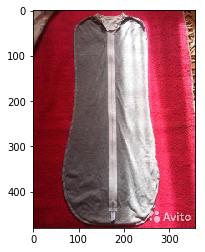

In [9]:
# Plot an image
img = Image.open(train_sample_dir + train_sample_df["image"][0]+".jpg")
plt.imshow(img)